## ESTIMATING AND PREDICTING THE VOLATILITY OF FINANCIAL MARKETS USING VECTOR ARMA-GARCH MODELS: AN APPLICATION ON NIGERIA STOCK EXCHANGE MARKET

### Dataset:

The dataset for this project can be downloaded from [Nigeria Stock Exchange](https://drive.google.com/file/d/17oMkq-qDt9_ZNKzsslJu5Qr7skt7RhWK/view?usp=share_link)

In [2]:
# Importing libraries
from logging import warning
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import re
import requests
from bs4 import BeautifulSoup
import selenium as sl
import lxml
from sklearn.preprocessing import scale, MinMaxScaler, PowerTransformer
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA, ARMA
from scipy.stats.distributions import chi2
from statsmodels.tsa.api import VAR, VARMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.tsa.vector_ar.vecm import coint_johansen, JohansenTestResult
from statsmodels.tools.eval_measures import aic, rmse, mse
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, r2_score, mean_squared_error
from sklearn.model_selection import train_test_split, TimeSeriesSplit, ParameterGrid
from sklearn.utils.validation import check_is_fitted
from scipy.stats import boxcox, probplot, jarque_bera
from statsmodels.stats.stattools import durbin_watson
import pylab
from datetime import date
import mgarch
import datetimerange
from arch import arch_model
import mvarch # Multivariate GARCH models
import scrapy
from pmdarima.arima import auto_arima
from timeit import default_timer as timer

from warnings import filterwarnings
filterwarnings('ignore')
%matplotlib inline

## Wrangle (Prepare) Data

### Import dataset

In [3]:
df_ = pd.read_csv('all_share_index.csv')
# Make a copy of the dataset
df = df_.copy()
# View the 1st 10 observations
df.head(10)

,Date,Price,Open,High,Low,Volume,Change %
0,12/2/2022,47531.84,47565.92,47572.78,47529.93,155.18,-0.07
1,12/1/2022,49626.05,49695.12,49703.85,49626.05,86.59,-0.14
2,11/30/2022,49664.07,50017.51,50017.51,49371.37,272.07,-0.70
3,11/29/2022,52917.76,52844.84,53069.29,52843.48,426.02,0.15
4,11/28/2022,47205.03,46872.25,47231.66,46872.25,245.42,0.72
5,11/25/2022,44608.82,43859.30,44609.24,43858.36,266.31,1.71
6,11/24/2022,46604.94,46232.60,46604.94,46188.70,138.60,0.81
7,11/23/2022,46232.37,44934.73,46232.37,44899.66,185.59,2.90
8,11/22/2022,44929.33,44662.96,44976.21,44662.96,126.08,0.51
9,11/21/2022,44701.84,44492.73,44701.84,44492.73,159.56,0.47


### Asses dataset

In [4]:
print(f"Shape of dataset is: {df.shape}")
print(f"Checking for null values:\n {df.isna().sum()} ")
df.info()

Shape of dataset is: (1216, 7)
Checking for null values:
 Date          0
Price         0
Open          0
High          0
Low           0
Volume      161
Change %      0
dtype: int64 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1216 entries, 0 to 1215
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Date      1216 non-null   object 
 1   Price     1216 non-null   float64
 2   Open      1216 non-null   float64
 3   High      1216 non-null   float64
 4   Low       1216 non-null   float64
 5   Volume    1055 non-null   float64
 6   Change %  1216 non-null   float64
dtypes: float64(6), object(1)
memory usage: 66.6+ KB


### Clean dataset

In [5]:
# Change the date format from object to date
df['Date'] = pd.to_datetime(df['Date'])

In [6]:
# Inspect volume for missing data
df['Volume'].isnull().sum()

161

In [7]:
# impute null values with mean in Vol column
mean = df['Volume'].mean()
df['Volume'] = df['Volume'].fillna(mean)

In [8]:
# Drop 'Change' variable as it is not needed in the study
df.drop(columns= 'Change %', axis=1, inplace=True)

In [9]:
# Change the index column
df.set_index('Date', inplace=True)

### Re-assess Dataset

In [10]:
# Re-assing the data
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1216 entries, 2022-12-02 to 2018-01-02
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Price   1216 non-null   float64
 1   Open    1216 non-null   float64
 2   High    1216 non-null   float64
 3   Low     1216 non-null   float64
 4   Volume  1216 non-null   float64
dtypes: float64(5)
memory usage: 57.0 KB
None


,Price,Open,High,Low,Volume
Date,,,,,
2022-12-02,47531.84,47565.92,47572.78,47529.93,155.18
2022-12-01,49626.05,49695.12,49703.85,49626.05,86.59
2022-11-30,49664.07,50017.51,50017.51,49371.37,272.07
2022-11-29,52917.76,52844.84,53069.29,52843.48,426.02
2022-11-28,47205.03,46872.25,47231.66,46872.25,245.42


In [11]:
# Save clean data
df.to_csv('all_share_index_clean.csv')

### Explore Dataset

In [12]:
# Checking the statistical properties of the dataset
df.describe().round(2).to_csv("descriptive_statistics.csv")

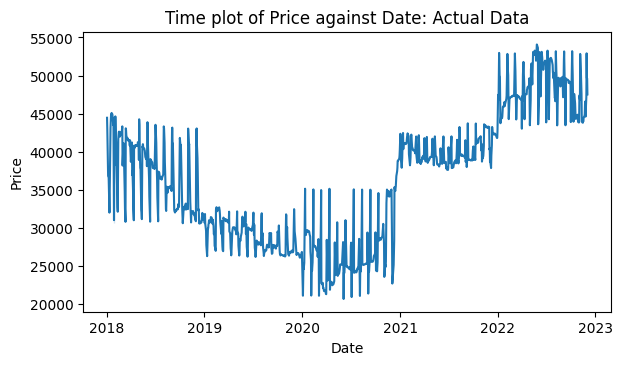

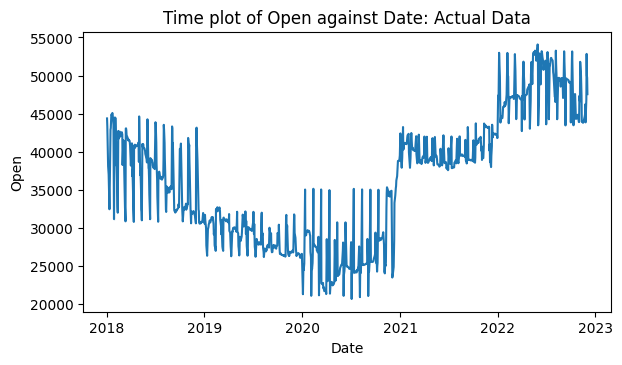

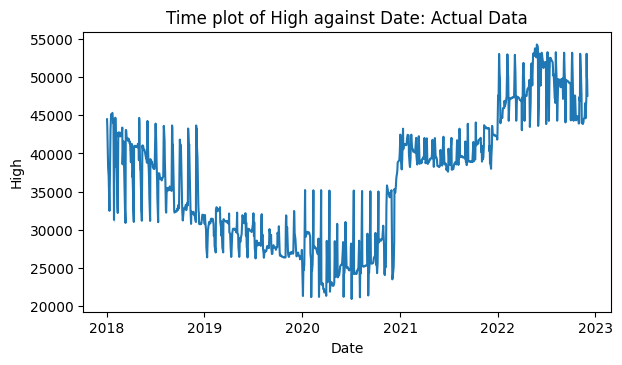

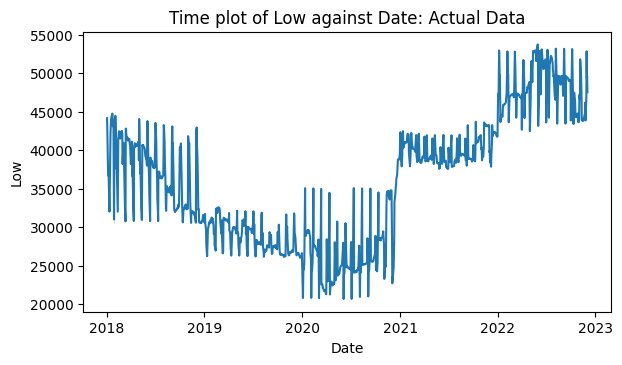

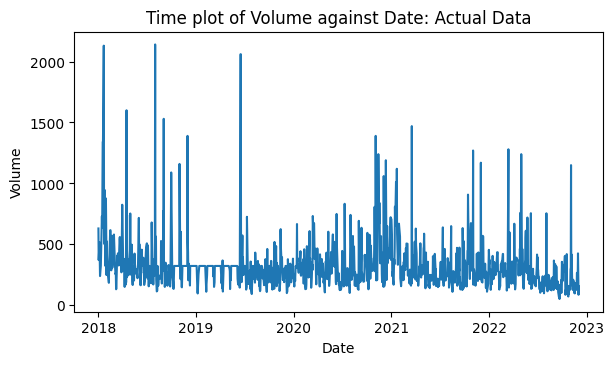

In [13]:
# Time series plot of dataset
def time_series_plot(data):
    cols = data.columns

    for c in cols:
        plt.figure(figsize=[15,8])
        plt.subplot(222)
        sns.lineplot(data=data, x = data.index, y = data[str(c)])
        plt.title('Time plot of ' + str(c) + ' ' + 'against Date: Actual Data')
        plt.xlabel('Date')
        plt.ylabel(str(c))
        plt.savefig(str(c) + '_Time_Series_Plot.jpg', bbox_inches = 'tight', dpi = 150)
          

time_series_plot(df)


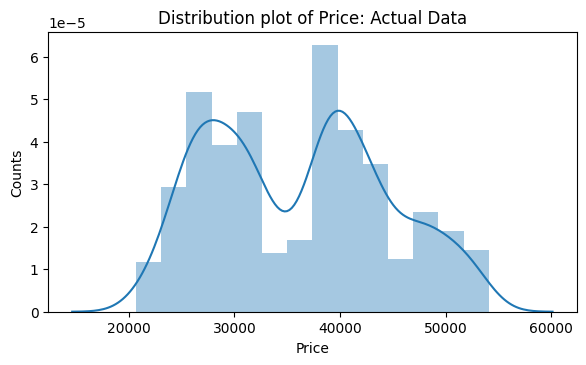

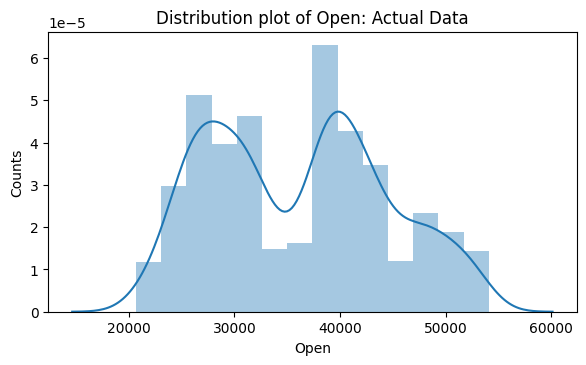

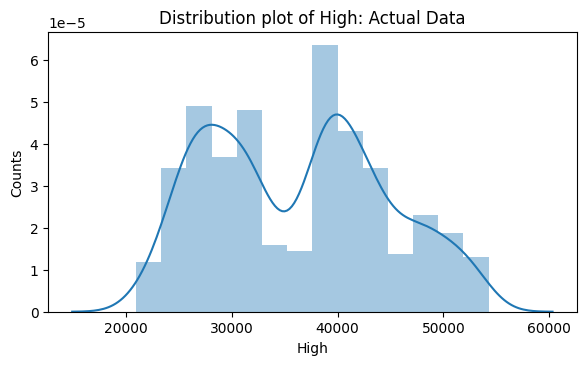

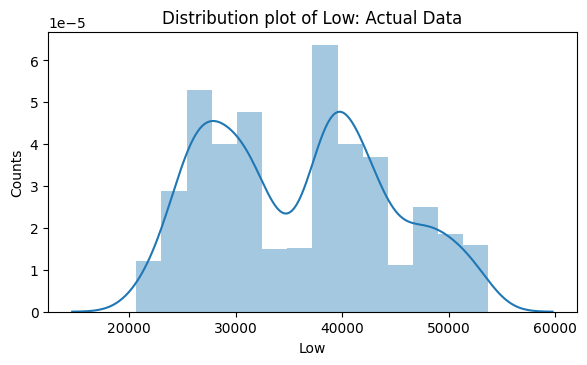

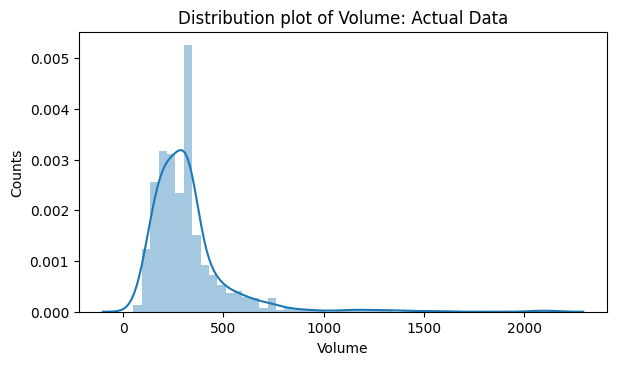

In [14]:
# Plotting for distribution of datapoints of the data

def distribution_plot(data):

    cols = data.columns

    for c in cols:
        plt.figure(figsize=[15,8])
        plt.subplot(222)
        sns.distplot(data[str(c)])
        plt.title('Distribution plot of ' + str(c) +': Actual Data')
        plt.xlabel(str(c))
        plt.ylabel('Counts')
        plt.savefig(str(c)+'_Dist_Series_Plot.jpg', bbox_inches = 'tight', dpi = 150)


distribution_plot(df)

<Figure size 2500x800 with 0 Axes>

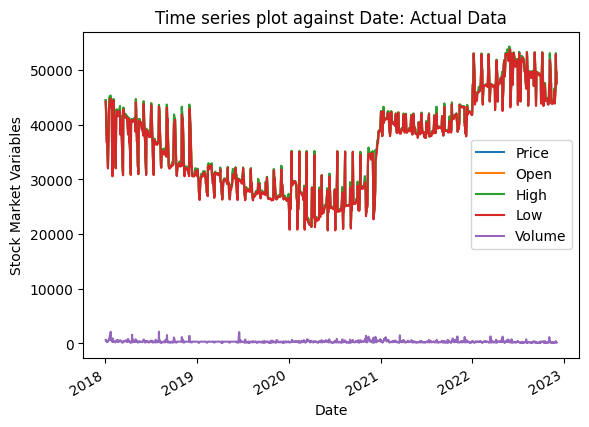

In [15]:
# Plot variables on same axis

plt.figure(figsize=[25,8])
df.plot()
plt.title('Time series plot against Date: Actual Data')
plt.xlabel('Date')
plt.ylabel('Stock Market Variables')
plt.savefig('Multariate_Time_plot.jpeg', bbox_inches='tight', dpi=150);

### Unit Root (Stationarity) Test

**1. Test**: The augmented Dickey-Fuller (ADF) test is used to test for stationarity in the time series datasets with the following hypotheses:

    1. H0: Series has unit root and is not stationary
    2. H1: Series does not have unit root and is stationary.

**2. Conclusion**: The following conclusions are drawn:

    1. All the time series variables/ features were non-stationary before splitting.

In [16]:
# Testing for stationarity using ADF test

def adf_test(series, col_name):
    print(f'Results for Dickey_Fuller Test for column: {col_name}')
    df_test = adfuller(series, autolag='AIC')
    df_output = pd.Series(df_test[:4], index=['Test Statistic', 'p-value', 
    'No Lags Used','Number of Observations Used'])
    for key,value in df_test[4].items():
        df_output['Critical Value {} '.format(key)] = value
        # df_output['Critical Value (%s) '%key] = value
    print(df_output)
    if df_test[1] <= 0.05:
        print("Conclusion:====>")
        print("Reject the null hypothesis")
        print("Data is stationary")
        print('='*50)
    else:
        print("Conclusion:====>")
        print("Fail to reject the null hypothesis")
        print("Data is non-stationary") 
        print('='*50)    
    
# Checking for stationarity
for name, column in df[df.columns].iteritems():
    adf_test(df[name],name)
    print('\n')


Results for Dickey_Fuller Test for column: Price
Test Statistic                   -1.081143
p-value                           0.722533
No Lags Used                     23.000000
Number of Observations Used    1192.000000
Critical Value 1%                -3.435848
Critical Value 5%                -2.863968
Critical Value 10%               -2.568063
dtype: float64
Conclusion:====>
Fail to reject the null hypothesis
Data is non-stationary


Results for Dickey_Fuller Test for column: Open
Test Statistic                   -1.057271
p-value                           0.731808
No Lags Used                     23.000000
Number of Observations Used    1192.000000
Critical Value 1%                -3.435848
Critical Value 5%                -2.863968
Critical Value 10%               -2.568063
dtype: float64
Conclusion:====>
Fail to reject the null hypothesis
Data is non-stationary


Results for Dickey_Fuller Test for column: High
Test Statistic                   -1.067854
p-value                   

### Splitting Data

In [17]:
# Split dataset

cutoff = int(len(df)*0.1)
df_train, df_test = df[cutoff: ], df[ : cutoff]
print(f"The sizes of the train and test datasets are: {df_train.shape[0]} and {df_test.shape[0]}")
df_train.head()

The sizes of the train and test datasets are: 1095 and 121


,Price,Open,High,Low,Volume
Date,,,,,
2022-06-09,49644.92,49991.41,49994.14,49639.64,138.94
2022-06-07,51556.54,51586.50,51612.97,51553.86,135.26
2022-06-06,53086.86,52908.24,53090.16,52889.13,755.62
2022-06-05,50937.01,50838.10,50993.59,50838.10,466.28
2022-06-04,46766.16,46775.76,46785.41,46751.63,261.59


## Model Building

### **Train Model**

### Unit Root (Stationarity) Test

**1. Test**: The augmented Dickey-Fuller (ADF) test is used to test for stationarity in the train time series datasets with the following hypotheses:

    1. H0: Series has unit root and is not stationary
    2. H1: Series does not have unit root and is stationary.

**2. Conclusion**: The following conclusions are drawn:

    1. The Volume column of the trained dataset was the only stationary variable.
    2. All variables of the training data were stationary at first degree or order differencing.

In [18]:
# Checking for stationarity
for name, column in df_train[df_train.columns].iteritems():
    adf_test(df_train[name],name)
    print('\n')

Results for Dickey_Fuller Test for column: Price
Test Statistic                   -2.375124
p-value                           0.148881
No Lags Used                     22.000000
Number of Observations Used    1072.000000
Critical Value 1%                -3.436465
Critical Value 5%                -2.864240
Critical Value 10%               -2.568208
dtype: float64
Conclusion:====>
Fail to reject the null hypothesis
Data is non-stationary


Results for Dickey_Fuller Test for column: Open


Test Statistic                   -2.357124
p-value                           0.154205
No Lags Used                     22.000000
Number of Observations Used    1072.000000
Critical Value 1%                -3.436465
Critical Value 5%                -2.864240
Critical Value 10%               -2.568208
dtype: float64
Conclusion:====>
Fail to reject the null hypothesis
Data is non-stationary


Results for Dickey_Fuller Test for column: High
Test Statistic                   -2.365173
p-value                           0.151808
No Lags Used                     22.000000
Number of Observations Used    1072.000000
Critical Value 1%                -3.436465
Critical Value 5%                -2.864240
Critical Value 10%               -2.568208
dtype: float64
Conclusion:====>
Fail to reject the null hypothesis
Data is non-stationary


Results for Dickey_Fuller Test for column: Low
Test Statistic                   -2.386554
p-value                           0.145567
No Lags Used                     

In [19]:
# Transforming trained dataset by differencing

df_train_tr = df_train.diff()
df_train_tr.dropna(inplace=True)

In [20]:
# Checking for stationarity in transformed training dataset
for name, column in df_train_tr[df_train_tr.columns].iteritems():
    adf_test(df_train_tr[name],name)
    print('\n')

Results for Dickey_Fuller Test for column: Price
Test Statistic                -9.886132e+00
p-value                        3.659967e-17
No Lags Used                   2.200000e+01
Number of Observations Used    1.071000e+03
Critical Value 1%             -3.436470e+00
Critical Value 5%             -2.864242e+00
Critical Value 10%            -2.568209e+00
dtype: float64
Conclusion:====>
Reject the null hypothesis
Data is stationary


Results for Dickey_Fuller Test for column: Open
Test Statistic                -9.811406e+00
p-value                        5.644193e-17
No Lags Used                   2.200000e+01
Number of Observations Used    1.071000e+03
Critical Value 1%             -3.436470e+00
Critical Value 5%             -2.864242e+00
Critical Value 10%            -2.568209e+00
dtype: float64
Conclusion:====>
Reject the null hypothesis
Data is stationary


Results for Dickey_Fuller Test for column: High
Test Statistic                -9.821471e+00
p-value                        5.32

In [21]:
# Saving the train and test dataset
df_test.to_csv("df_test.csv")
df_train.to_csv("df_train.csv")
df_train_tr.to_csv("df_train_transf.csv")


### Distribution Plot for Training Data

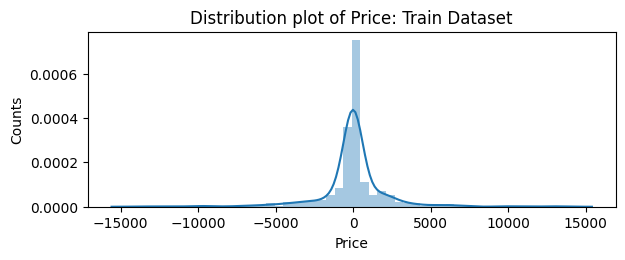

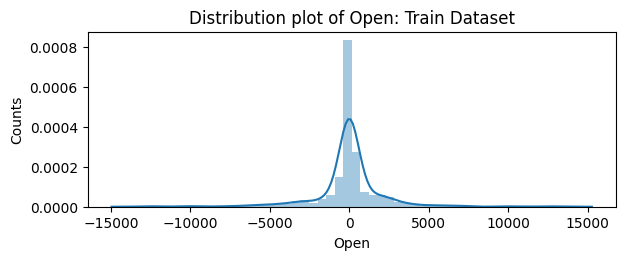

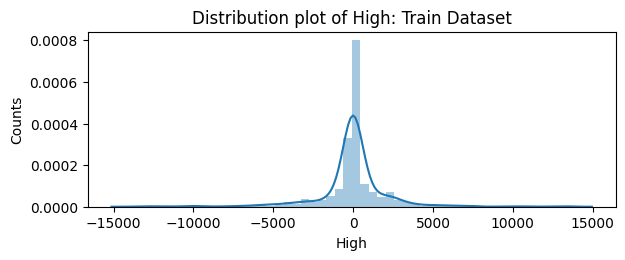

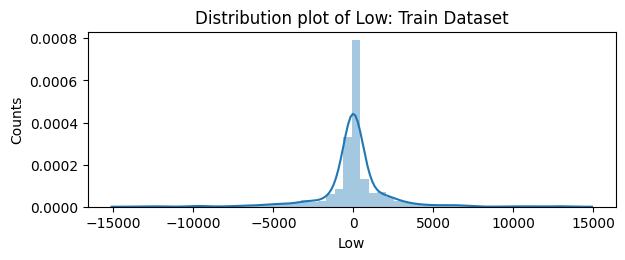

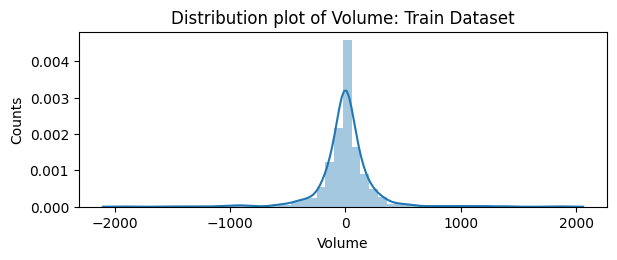

In [22]:
# Plotting for distribution of datapoints of the training data

def distribution_plot(data):

    cols = data.columns

    for c in cols:
        plt.figure(figsize=[15,5])
        plt.subplot(221)
        sns.distplot(data[str(c)])
        plt.title('Distribution plot of ' + str(c)+ ': Train Dataset')
        plt.xlabel(str(c))
        plt.ylabel('Counts')
        plt.savefig(str(c) +'_dist_train_trans_plot.jpeg', bbox_inches = 'tight', dpi = 150)


distribution_plot(df_train_tr)

<Figure size 2000x500 with 0 Axes>

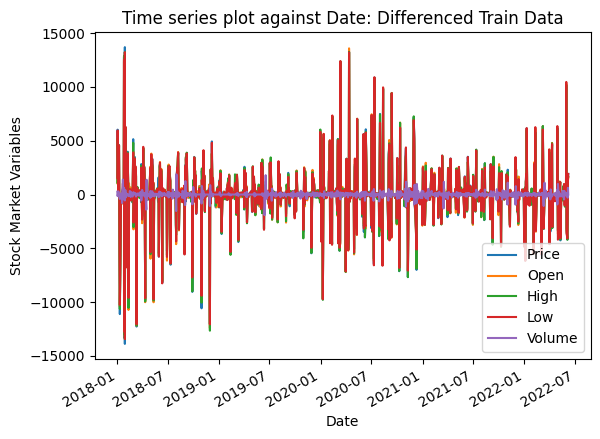

In [23]:
# Plot variables on same axis

def time_series_plot_diff(data):
    plt.figure(figsize=[20,5])
    data.plot()
    plt.title('Time series plot against Date: Differenced Train Data')
    plt.xlabel('Date')
    plt.ylabel('Stock Market Variables')
    plt.savefig('Multariate_Time_plot_Diff.jpeg', bbox_inches='tight', dpi=150);


time_series_plot_diff(df_train_tr)

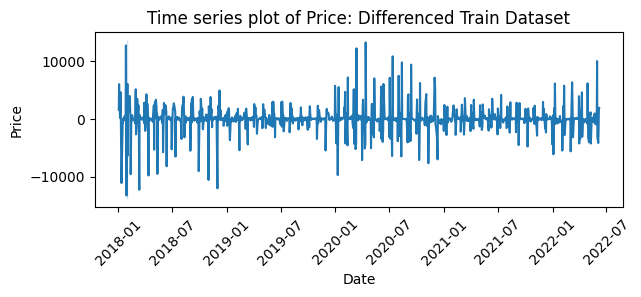

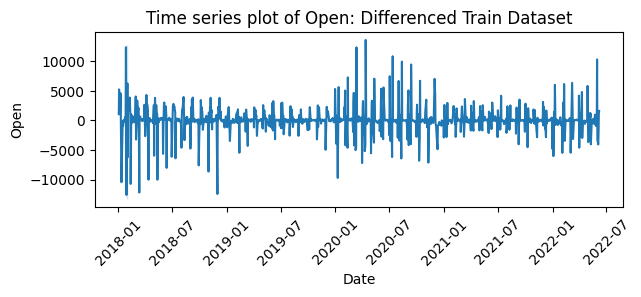

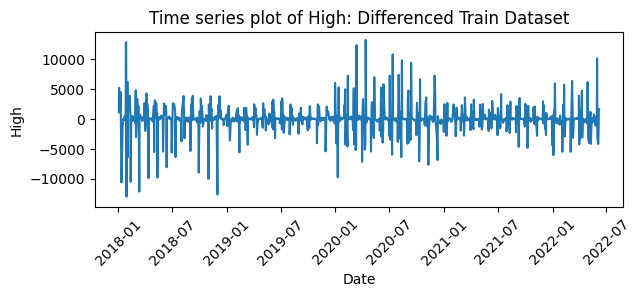

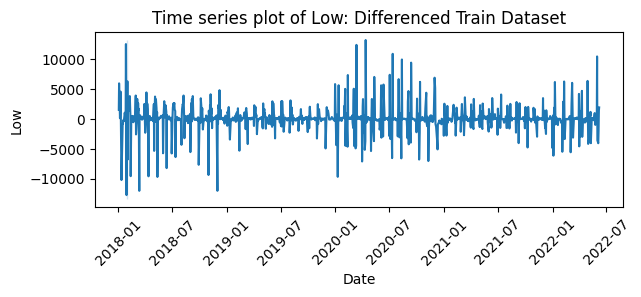

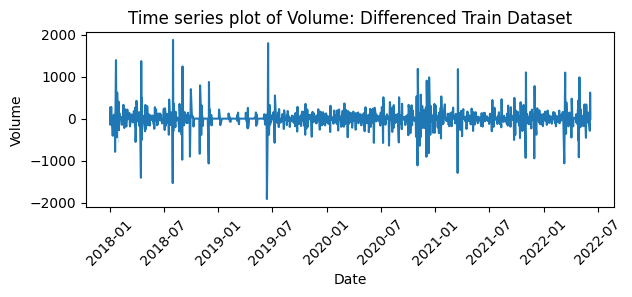

In [24]:
def time_series_plot_diff(data):
    
    cols = data.columns

    for c in cols:
        plt.figure(figsize=[15,5])
        plt.subplot(221)
        sns.lineplot(data[str(c)])
        plt.title('Time series plot of ' + str(c)+ ': Differenced Train Dataset')
        plt.xlabel('Date')
        plt.ylabel(str(c))
        plt.xticks(rotation=45)
        plt.savefig(str(c) +'_time_series_plot_diff_train.jpeg', bbox_inches = 'tight', dpi = 150)



time_series_plot_diff(df_train_tr)

#### **Confirm the correlation among the time series variables**:

**`Procedure`:**

Heatmap was used to check the correlation coefficient among the time series variables.

**`Conclusion`:**

The correlation coefficients for the 5 time series variables showed that there is very strong positive correlation among all the variables, with the exception of the `volume` variable which has very weak positive correlation with others. 

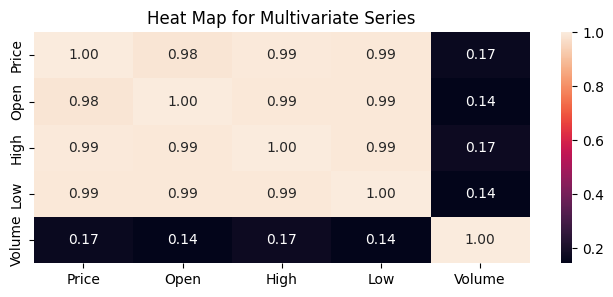

In [25]:
# Checking the correlation among the variables
plt.figure(figsize=[8,3])
cor_ = df_train_tr.corr()
# Making heatmaps of the variables
sns.heatmap(cor_, annot=True, fmt='.2f')
plt.title('Heat Map for Multivariate Series')
plt.savefig('Heatmap.jpg', bbox_inches='tight', dpi=150);

### **Johansen Cointegration Test:**

1. **`Test`**: This helps to check for existing relationship between the dependent (endogenous) time series variable and the explanatory (exogenous) time series variables in the long run.

2. **`Conclusion`**: The following conclusions are drawn:

    There is `long-term` relationship among the variables in the transformed training data.

In [26]:
# checking for conintegration in the variables of the training data

def coint_test (df):
    res = coint_johansen(df,-1,5)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = res.lr1
    cvts = res.cvt[:, d[str(1-0.05)]]
    def adjust(val, length= 6):
        return str(val).ljust(length)
    print('Cointegration results:')
    print('Column Name >    Test Stat >     C(95%) =>  Signif \n', '--'*25)
    for col, trace, cvt in zip(df.columns, traces, cvts):
        print(adjust(col), '> ', adjust(round(trace,2), 9),">", adjust(cvt, 8), ' => ' , trace > cvt)

coint_test(df_train_tr)

Cointegration results:
Column Name >    Test Stat >     C(95%) =>  Signif 
 --------------------------------------------------
Price  >  2061.3    > 60.0627   =>  True
Open   >  1564.2    > 40.1749   =>  True
High   >  1137.74   > 24.2761   =>  True
Low    >  724.94    > 12.3212   =>  True
Volume >  336.71    > 4.1296    =>  True


In [28]:
x = JohansenTestResult

#### **Evaluation Metrics: Loss Function**

In [29]:
# Defining a time series evaluation function

def series_eval_metric(y_actual, y_pred):

    mae_train = mean_absolute_percentage_error(y_actual, y_pred)
    mape_train = mean_absolute_percentage_error(y_actual, y_pred)
    r2_train = r2_score(y_actual, y_pred)
    mse_train = mean_squared_error(y_actual, y_pred)
    rmse_train = rmse(y_actual, y_pred)

    print(f"Evaluation metric results:-")
    print(f'MAE is : {mae_train}')
    print(f'MAPE is : {mape_train}')
    print(f'R2 is : {r2_train}')
    print(f'MSE is : {mse_train}')
    print(f'RMSE is : {rmse_train}', end='\n\n')


#### **Dataset Inversion**

In [30]:
# Defining the inverse differencing equation

def inverse_diff(actual_df, pred_df):
    df_res = pred_df.copy()
    cols = actual_df.columns
    for col in cols:
        df_res[str(col)+'_forecast'] = actual_df[col].iloc[-1] + df_res[str(col)].cumsum()
    return df_res

## VAR MODEL

In [31]:
# VAR Model

# Determine order of VAR model by hyperparameter tuning
def var_order(df):
    print('VAR order determination:')
    for i in range(1,11):
        model = VAR(df)
        results = model.fit(i)
        print(f'Order: {i}, AIC: {results.aic}, BIC: {results.bic}')

var_order(df_train_tr)

VAR order determination:
Order: 1, AIC: 57.95539544652579, BIC: 58.092541324517825
Order: 2, AIC: 57.58858362557463, BIC: 57.84020188436288
Order: 3, AIC: 57.36264364456104, BIC: 57.728902121982344
Order: 4, AIC: 57.23546614768518, BIC: 57.71653308566539
Order: 5, AIC: 57.155571176146054, BIC: 57.751615222042545
Order: 6, AIC: 57.056646030955974, BIC: 57.76783623890585
Order: 7, AIC: 57.033812353985404, BIC: 57.860318186259384
Order: 8, AIC: 56.97173164677637, BIC: 57.91372297513848
Order: 9, AIC: 56.979345759483365, BIC: 58.03699286655631
Order: 10, AIC: 56.9553504518077, BIC: 58.128824032444136


In [32]:
# Fitting VAR model
model = VAR(df_train_tr).fit(7)
display(model.summary())

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 12, Jun, 2023
Time:                     09:11:02
--------------------------------------------------------------------
No. of Equations:         5.00000    BIC:                    57.8603
Nobs:                     1087.00    HQIC:                   57.3467
Log likelihood:          -38529.8    FPE:                5.88197e+24
AIC:                      57.0338    Det(Omega_mle):     4.99772e+24
--------------------------------------------------------------------
Results for equation Price
               coefficient       std. error           t-stat            prob
----------------------------------------------------------------------------
const           -18.603305        64.034262           -0.291           0.771
L1.Price         -0.704417         0.520774           -1.353           0.176
L1.Open           1.527157         0.508033            3.006           0.003

### Fit VARMA Model

#### Determine order of the model:

This seeks to fit the varma(p,q) model on the multivariate time series features and draw conclusion as well. The `VARMA` model is fitted for AR(p) and MA(q) terms using the `auto_arima` model and the best hyperparameter chosen.

**Conclusion:** 

Having applied various methods to obtain the best hyperparameter for the `VARMA` model, the best hyperparameter for the models is: `[(2,0,3),(1,0,1),(2,0,3),(2,0,3),(2,0,1)]`. At the end, the best hyperparameters for the model is VARMA(1,1)

In [143]:
# Obtaining the optimum param_grid search for VARMA model

def param_grid_select(data):
     cols = data.columns
     param_pq = []
     for c in cols:
          print(f'Grid_search for {str(c)}: ')
          param_grid = auto_arima(data[str(c)], start_p=0, start_q=0,
          max_order=3, test='adf', error_action='ignore',trace=True, seasonal=False, scoring='mse')
          param_pq.append(param_grid.get_params().get('order'))
          print('='*50)
     print(f"Best VARMA hyperparemeter, (param_pq): {param_pq}")


param_grid_select(df_train_tr)

Grid_search for Price: 
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=20033.077, Time=0.37 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=19996.196, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=19987.286, Time=0.13 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=19877.758, Time=0.43 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=19884.375, Time=0.42 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=19881.226, Time=0.26 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=19966.964, Time=0.11 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=19989.633, Time=0.07 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=19876.268, Time=0.60 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=19877.326, Time=0.75 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=19842.675, Time=1.76 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=19877.230, Time=0.44 sec
 ARIMA(3,0,3)(0,0,0)[0]             : AIC=19858.286, Time=2.63 sec
 ARIMA(2,0,4)(0,0,0)[0]             : AIC=19869.268, Time=0.95

In [146]:
# Getting grid search for the model hyperparameters

def param_grid_select():
    pq = []
    for name, column in df_train_tr[['Price','Open', 'High', 'Low','Volume']].iteritems():
        print(f'Searching order of p and q for : {name}')
        stepwise_model = auto_arima(df_train_tr[name],start_p=0, start_q=0,max_p=7, max_q=7, seasonal=False,test='adf',
        trace=True,error_action='ignore',suppress_warnings=True, stepwise=True,maxiter=1000, scoring='mse')
        parameter = stepwise_model.get_params().get('order')
        print(f'optimal order for:{name} is: {parameter} \n\n')
        pq.append(stepwise_model.get_params().get('order'))
        print("="*50)
    print(f"Best VARMA hyperparemeter, (p,q): {pq}")


param_grid_select()

Searching order of p and q for : Price
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=20033.077, Time=0.05 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=19996.196, Time=0.07 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=19987.286, Time=0.07 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=19877.758, Time=0.43 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=19884.375, Time=0.39 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=19881.226, Time=0.28 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=19966.964, Time=0.13 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=19989.633, Time=0.06 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=19876.268, Time=0.60 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=19877.326, Time=0.74 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=19842.675, Time=1.31 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=19877.230, Time=0.59 sec
 ARIMA(3,0,3)(0,0,0)[0]             : AIC=inf, Time=3.64 sec
 ARIMA(2,0,4)(0,0,0)[0]             : AIC=19869.268, 

In [149]:
"""Combining the best parameters for each variable to obtain the best (p,q) order
for the VARMA model """
pq = [(2, 0, 3), (1, 0, 1), (2, 0, 3), (2, 0, 3), (2, 0, 1)]

df_result_VARMA = pd.DataFrame(columns=['p', 'q', 'tr','RMSE Price','RMSE Open','RMSE High','RMSE Low', 'RMSE Volume'])
print('starting grid search...')

for i in pq:
    if i[0]== 0 and i[2] ==0:
        pass
    else:
        print(f' Running for {i}')
        model = VARMAX(df_train_tr, order=(i[0],i[2])).fit(disp=False)
        result = model.forecast(y=df_test[['Price','Open', 'High', 'Low','Volume']].values,steps = len(df_test))
        inv_res = inverse_diff(df_train_tr, result)
        pricermse = rmse(df_test.Price, inv_res.Price_forecast)
        openrmse = rmse(df_test.Open, inv_res.Open_forecast)
        highrmse = rmse(df_test.High, inv_res.High_forecast)
        lowrmse = rmse(df_test.Low, inv_res.Low_forecast)
        volrmse = rmse(df_test.Volume, inv_res.Volume_forecast)
        df_result_VARMA = df_result_VARMA.append({'p': i[0], 'q': i[2], 'RMSE Price': pricermse,'RMSE Open':openrmse,'RMSE High':highrmse,'RMSE Low':lowrmse,'RMSE Volume':volrmse }, ignore_index=True)
df_result_VARMA.to_csv("VARMA_grid_param.csv")


starting grid search...
 Running for (2, 0, 3)
 Running for (1, 0, 1)
 Running for (2, 0, 3)
 Running for (2, 0, 3)
 Running for (2, 0, 1)


<Figure size 1500x600 with 0 Axes>

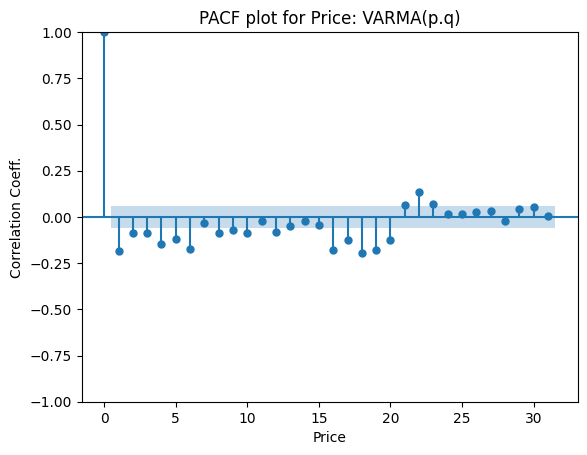

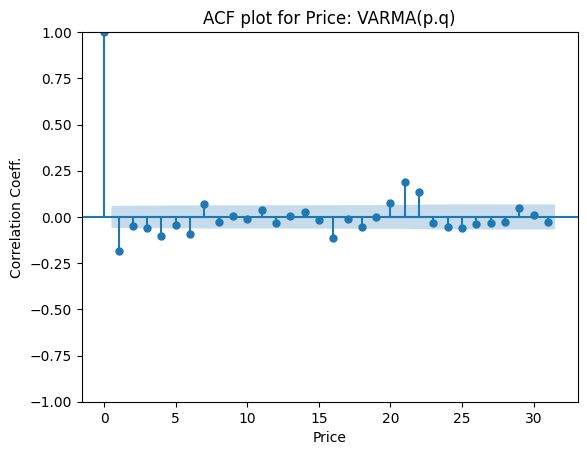

<Figure size 1500x600 with 0 Axes>

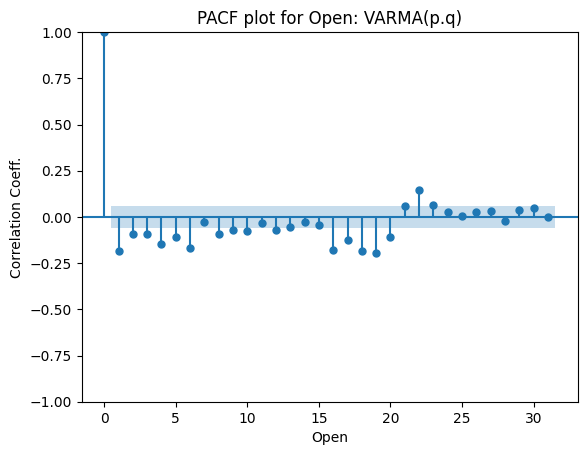

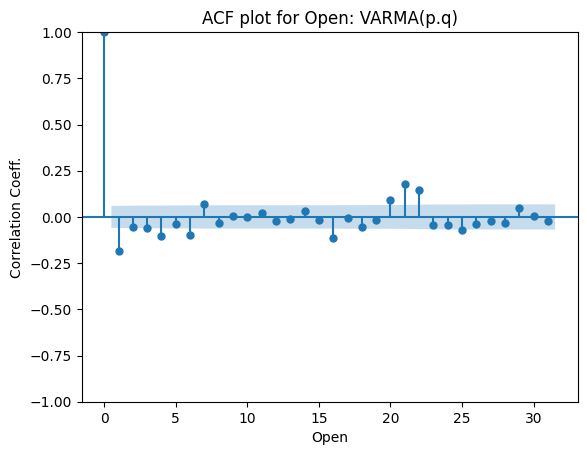

<Figure size 1500x600 with 0 Axes>

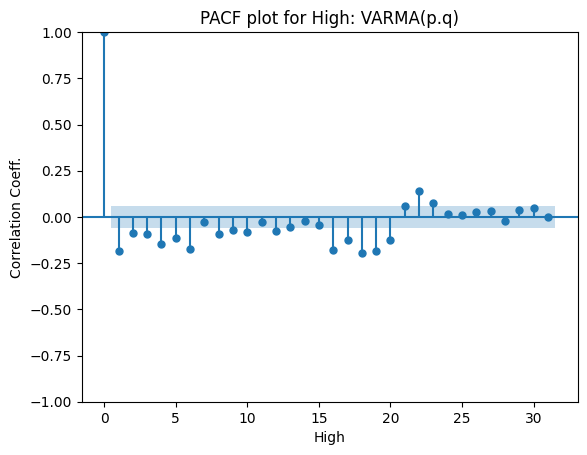

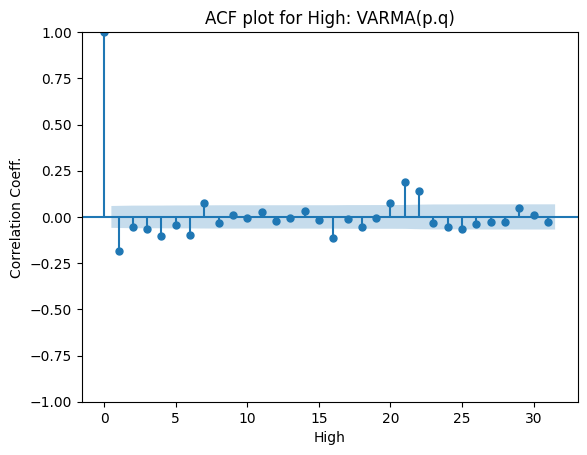

<Figure size 1500x600 with 0 Axes>

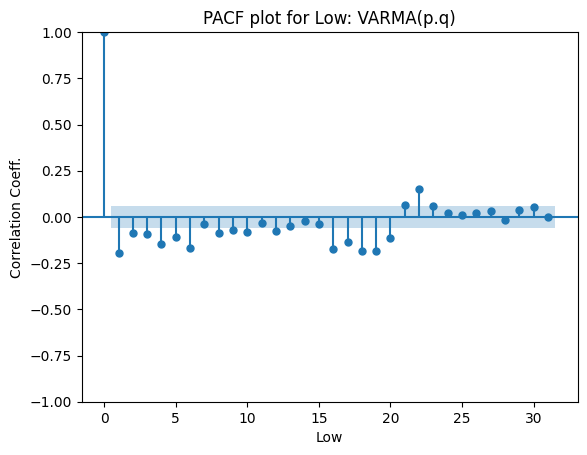

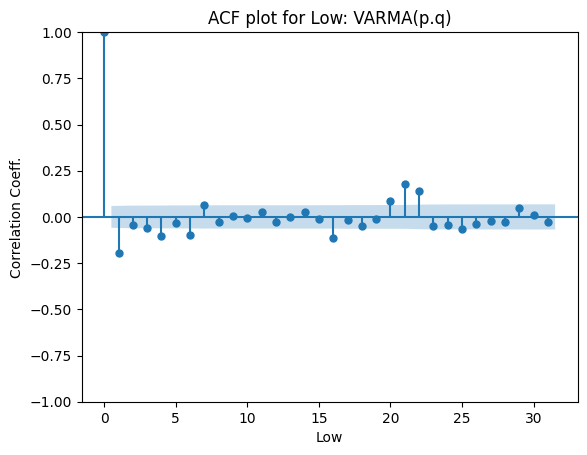

<Figure size 1500x600 with 0 Axes>

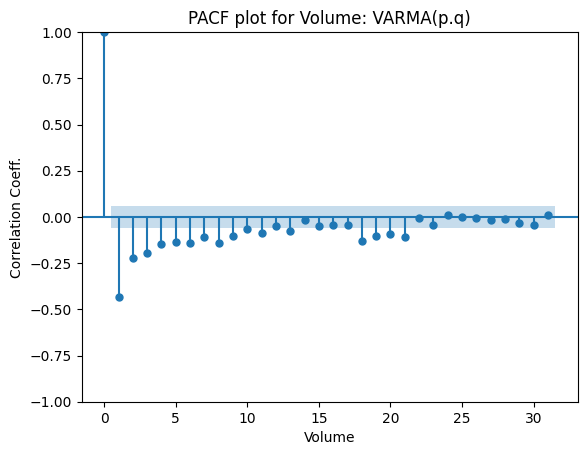

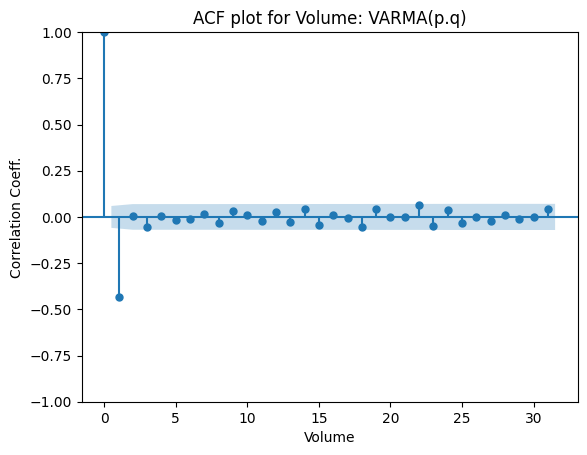

In [164]:
# Alternative parameters selection for the VARMA model using pacf and acf

def plot_pacf_acf (data):
    cols = data.columns
    for col in cols:
        plt.figure(figsize=[15,6])
        plot_pacf(data[str(col)], title=f"PACF plot for {str(col)}: VARMA(p.q)")
        plt.xlabel(f"{str(col)}")
        plt.ylabel("Correlation Coeff.")
        plt.savefig(str(col)+"_pacf_plots.jpg", bbox_inches='tight', dpi=150);
        plot_acf(data[str(col)], title=f"ACF plot for {str(col)}: VARMA(p.q)")
        plt.xlabel(f"{str(col)}")
        plt.ylabel("Correlation Coeff.")
        plt.savefig(str(col)+"_acf_plots.jpg", bbox_inches='tight', dpi=150);
        

plot_pacf_acf(df_train_tr)

In [188]:
# Obtaining the least RMSE values for each feature by sorting in ascendng order of the best (p,q) order
df_result_VARMA.sort_values(['RMSE Price','RMSE Open','RMSE High','RMSE Low','RMSE Volume']).to_csv("rmse_best_varma_param.csv", index=False)
df_result_VARMA

In [167]:
# Selecting the best hyperparameter for the VARMA models
best_VARMA_param = df_result_VARMA.iloc[1,:2]
best_VARMA_param


p    1.0
q    1.0
Name: 1, dtype: object

### Fitting the VARMA(1,1) Model on Training Dataset


In [16]:
# Fitting VARMA model on train dataset

model = VARMAX(df_train_tr, order=(1,1), trend='c').fit(disp=False)


In [17]:
model.summary()

Dep. Variable:,"['Price', 'Open', 'High', 'Low', 'Volume']",No. Observations:,1094
Model:,"VARMA(1,1)",Log Likelihood,-39006.207
,+ intercept,AIC,78152.414
Date:,"Fri, 20 Jan 2023",BIC,78502.246
Time:,17:17:20,HQIC,78284.793
Sample:,0,,
,- 1094,,
Covariance Type:,opg,,
Ljung-Box (L1) (Q):,"2.03, 3.71, 1.69, 0.00, 11.09",Jarque-Bera (JB):,"3737.90, 559.03, 1060.26, 2366.16, 18420.11"
Prob(Q):,"0.15, 0.05, 0.19, 0.97, 0.00",Prob(JB):,"0.00, 0.00, 0.00, 0.00, 0.00"
Heteroskedasticity (H):,"2.50, 1.33, 1.47, 1.94, 1.54",Skew:,"-0.32, -0.28, 1.34, -1.56, 2.51"


### Diagnostic Check on the VARMA(1,1) Model: 

### **Test of `Residuals` Autocorrelation: Durbin Watson Test**:

**1. Test:** Durbin Watson test is used to test for autocorrelation in the residuals. 

`Properties of Durbin Watson, DW, Test`:

1. `DW` statistic ranges from `0 to 4`, with `2` denoting `zero autocorrelation`.
2. There is `positive autocorrelation` when `DW < 2`, and there is `negative autocorrelation` when `DW > 2`.

        1.  H0: There is no `autocorrelation (serial correlation)` among the `residuals`.
        2.  H1: There is `autocorrelation (serial correlation)` among the `residuals`.

**2. Conclusion:**

The result of the `Durbin Watson` test shows that there is no serial autocorrelation among the residuals. Hence, the model can be used to make further predictions.


In [32]:
def durbin_watson_test(df=None, resid=None):
    cols, stat = [], []
    result = durbin_watson(resid)
    for col, val in zip(df.columns, result.round(1)):
        cols.append(col)
        stat.append(round(val, 2))
    dw_test = pd.DataFrame(stat, index=cols, columns={'dw_statistic':stat})
    dw_test.to_csv("durbin_watson_test.csv")
    return dw_test


durbin_watson_test(df_train_tr, model.resid)

,dw_statistic
Price,1.9
Open,1.9
High,1.9
Low,1.9
Volume,2.2


In [34]:
# Jarque-Bera Normality Test
result = jarque_bera(model.resid)
print(f"JB statistic: {result[0]}")
print(f"p-value: {result[1]}")

JB statistic: 31231.337740440133
p-value: 0.0


### Evaluate VARMA(p,q) Models Using Metric

In this section, the fitted models will be used to forecast the train (in-sample) and test (out-sample) datasets. Thereafter, the forecast values will be evaluated using the `evaluation metrics`.

#### `Conclusion`:

The following conclusion is drawn with the `VARMA(p,q)' models:

1. From the time series plots and the evaluation metrics of the in-sample (train) and out-sample (test) datasets, the model performed better in its predictions.



**`Note`**:

When making forecast for in-sample (train dataset), use the `predict` function. For out-sample (test datset), use the forecast function. The forecast function makes forecast with the `VARMAX` model starting from the last `datapoint` of the train dataset or the end of the train dataset.

[VARMAX Link 1](https://www.statsmodels.org/stable/generated/statsmodels.tsa.statespace.varmax.VARMAXResults.predict.html#statsmodels.tsa.statespace.varmax.VARMAXResults.predict)

[VARMAX Link 2](https://www.statsmodels.org/stable/generated/statsmodels.tsa.statespace.varmax.VARMAXResults.forecast.html)

In [171]:
# Viewing the transformed train data
print(df_train_tr.head())
df_train_tr.tail()

              Price     Open     High      Low  Volume
Date                                                  
2022-06-07  1911.62  1595.09  1618.83  1914.22   -3.68
2022-06-06  1530.32  1321.74  1477.19  1335.27  620.36
2022-06-05 -2149.85 -2070.14 -2096.57 -2051.03 -289.34
2022-06-04 -4170.85 -4062.34 -4208.18 -4086.47 -204.69
2022-06-01 -3158.22 -3299.01 -3177.47 -3605.86  -86.98


,Price,Open,High,Low,Volume
Date,,,,,
2018-01-11,-11112.35,-10440.85,-10641.45,-10256.17,-407.66364
2018-01-08,4606.18,4559.73,4545.19,4566.54,-82.87636
2018-01-06,203.46,1086.76,1125.27,103.88,276.79000
2018-01-03,6027.09,5226.00,5217.76,5951.42,-145.56000
2018-01-02,1616.80,1048.26,1117.83,1526.89,259.27000


In [172]:
# Predicting the transformed train data
pred_train = model.predict(start="2022-06-07", end="2018-01-02")
print(f"Length of original train dataset: {len(df_train)}")
print(f"Length of transformed train dataset: {len(df_train_tr)}")
print(f"Length of predicted train dataset: {len(pred_train)}")
print(pred_train.head())
pred_train.tail()

Length of original train dataset: 1095
Length of transformed train dataset: 1094
Length of predicted train dataset: 1094
                  Price         Open         High          Low      Volume
Date                                                                      
2022-06-07    -4.459534    -5.035853    -4.844379    -4.778603    0.723093
2022-06-06  -735.386354  -597.647856  -608.771506  -753.065656   -5.135342
2022-06-05  -708.743683  -568.115297  -613.065741  -617.900118 -297.855691
2022-06-04   613.743848   721.638757   639.990170   612.564504  -72.978626
2022-06-01  1107.737320  1208.392678  1175.695896  1129.229056   14.949118


,Price,Open,High,Low,Volume
Date,,,,,
2018-01-11,701.687879,722.414929,918.857352,870.209284,232.352564
2018-01-08,2901.446637,2573.937104,2685.959095,2593.952688,89.339131
2018-01-06,-969.159118,-1278.824728,-1117.392044,-1236.400501,181.925498
2018-01-03,916.016191,-134.034954,116.387645,697.549747,102.844915
2018-01-02,-1726.481408,-1969.832295,-1722.997675,-1900.467438,209.222733


In [173]:
# idx = pd.date_range(start='2022-06-09', end='2018-01-02', periods=len(df_train))

idx = pd.date_range(start="2022-06-07", end="2018-01-02", periods=len(df_train[1:]))
df_pred = pd.DataFrame(pred_train, columns=df_train_tr.columns)
# df_pred["new_index"] = range(len(df_train), len(df))
# df_pred = df_pred.set_index("new_index")
# df_pred.head()

train_pred_output = inverse_diff(df_train, pred_train)
train_pred_output.head()

,Price,Open,High,Low,Volume,Price_forecast,Open_forecast,High_forecast,Low_forecast,Volume_forecast
Date,,,,,,,,,,
2022-06-07,-4.459534,-5.035853,-4.844379,-4.778603,0.723093,44455.720466,44373.764147,44479.195621,44150.601397,631.243093
2022-06-06,-735.386354,-597.647856,-608.771506,-753.065656,-5.135342,43720.334112,43776.116290,43870.424114,43397.535741,626.107751
2022-06-05,-708.743683,-568.115297,-613.065741,-617.900118,-297.855691,43011.590429,43208.000993,43257.358374,42779.635624,328.252060
2022-06-04,613.743848,721.638757,639.990170,612.564504,-72.978626,43625.334277,43929.639750,43897.348544,43392.200128,255.273433
2022-06-01,1107.737320,1208.392678,1175.695896,1129.229056,14.949118,44733.071597,45138.032429,45073.044440,44521.429184,270.222551


In [174]:
# Viewing the predicted train dataset
train_pred_output.tail()

,Price,Open,High,Low,Volume,Price_forecast,Open_forecast,High_forecast,Low_forecast,Volume_forecast
Date,,,,,,,,,,
2018-01-11,701.687879,722.414929,918.857352,870.209284,232.352564,41110.547470,39061.539356,39938.544393,41261.123570,2041.283236
2018-01-08,2901.446637,2573.937104,2685.959095,2593.952688,89.339131,44011.994107,41635.476459,42624.503487,43855.076258,2130.622366
2018-01-06,-969.159118,-1278.824728,-1117.392044,-1236.400501,181.925498,43042.834990,40356.651731,41507.111444,42618.675757,2312.547864
2018-01-03,916.016191,-134.034954,116.387645,697.549747,102.844915,43958.851181,40222.616777,41623.499089,43316.225504,2415.392780
2018-01-02,-1726.481408,-1969.832295,-1722.997675,-1900.467438,209.222733,42232.369772,38252.784482,39900.501413,41415.758066,2624.615512


In [175]:
# Making a copy of the train dataset
# The first observation was lost during differencin of train dataset
df_train_c = df_train[1:]
df_train_c.head()

,Price,Open,High,Low,Volume
Date,,,,,
2022-06-07,51556.54,51586.50,51612.97,51553.86,135.26
2022-06-06,53086.86,52908.24,53090.16,52889.13,755.62
2022-06-05,50937.01,50838.10,50993.59,50838.10,466.28
2022-06-04,46766.16,46775.76,46785.41,46751.63,261.59
2022-06-01,43607.94,43476.75,43607.94,43145.77,174.61


In [176]:
# Making a copy of the predicted train dataset
df_train_pred = train_pred_output.loc[: , 'Price_forecast': ]
df_train_pred.head()

,Price_forecast,Open_forecast,High_forecast,Low_forecast,Volume_forecast
Date,,,,,
2022-06-07,44455.720466,44373.764147,44479.195621,44150.601397,631.243093
2022-06-06,43720.334112,43776.116290,43870.424114,43397.535741,626.107751
2022-06-05,43011.590429,43208.000993,43257.358374,42779.635624,328.252060
2022-06-04,43625.334277,43929.639750,43897.348544,43392.200128,255.273433
2022-06-01,44733.071597,45138.032429,45073.044440,44521.429184,270.222551


In [177]:
# Combining the actual train dataframe and the predicted train dataframe
df_train_comb = df_train_c.join(df_train_pred)
# Save the new dataframe
df_train_comb.to_csv("df_train_&_pred.csv")
print(f"Checking for null values in new dataframe:\n{df_train_comb.isna().sum()}")
df_train_comb.head()

Checking for null values in new dataframe:
Price              0
Open               0
High               0
Low                0
Volume             0
Price_forecast     0
Open_forecast      0
High_forecast      0
Low_forecast       0
Volume_forecast    0
dtype: int64


,Price,Open,High,Low,Volume,Price_forecast,Open_forecast,High_forecast,Low_forecast,Volume_forecast
Date,,,,,,,,,,
2018-01-02,44460.18,44378.80,44484.04,44155.38,630.52000,42232.369772,38252.784482,39900.501413,41415.758066,2624.615512
2018-01-03,42843.38,43330.54,43366.21,42628.49,371.25000,43958.851181,40222.616777,41623.499089,43316.225504,2415.392780
2018-01-06,36816.29,38104.54,38148.45,36677.07,516.81000,43042.834990,40356.651731,41507.111444,42618.675757,2312.547864
2018-01-08,36612.83,37017.78,37023.18,36573.19,240.02000,44011.994107,41635.476459,42624.503487,43855.076258,2130.622366
2018-01-11,32006.65,32458.05,32477.99,32006.65,322.89636,41110.547470,39061.539356,39938.544393,41261.123570,2041.283236


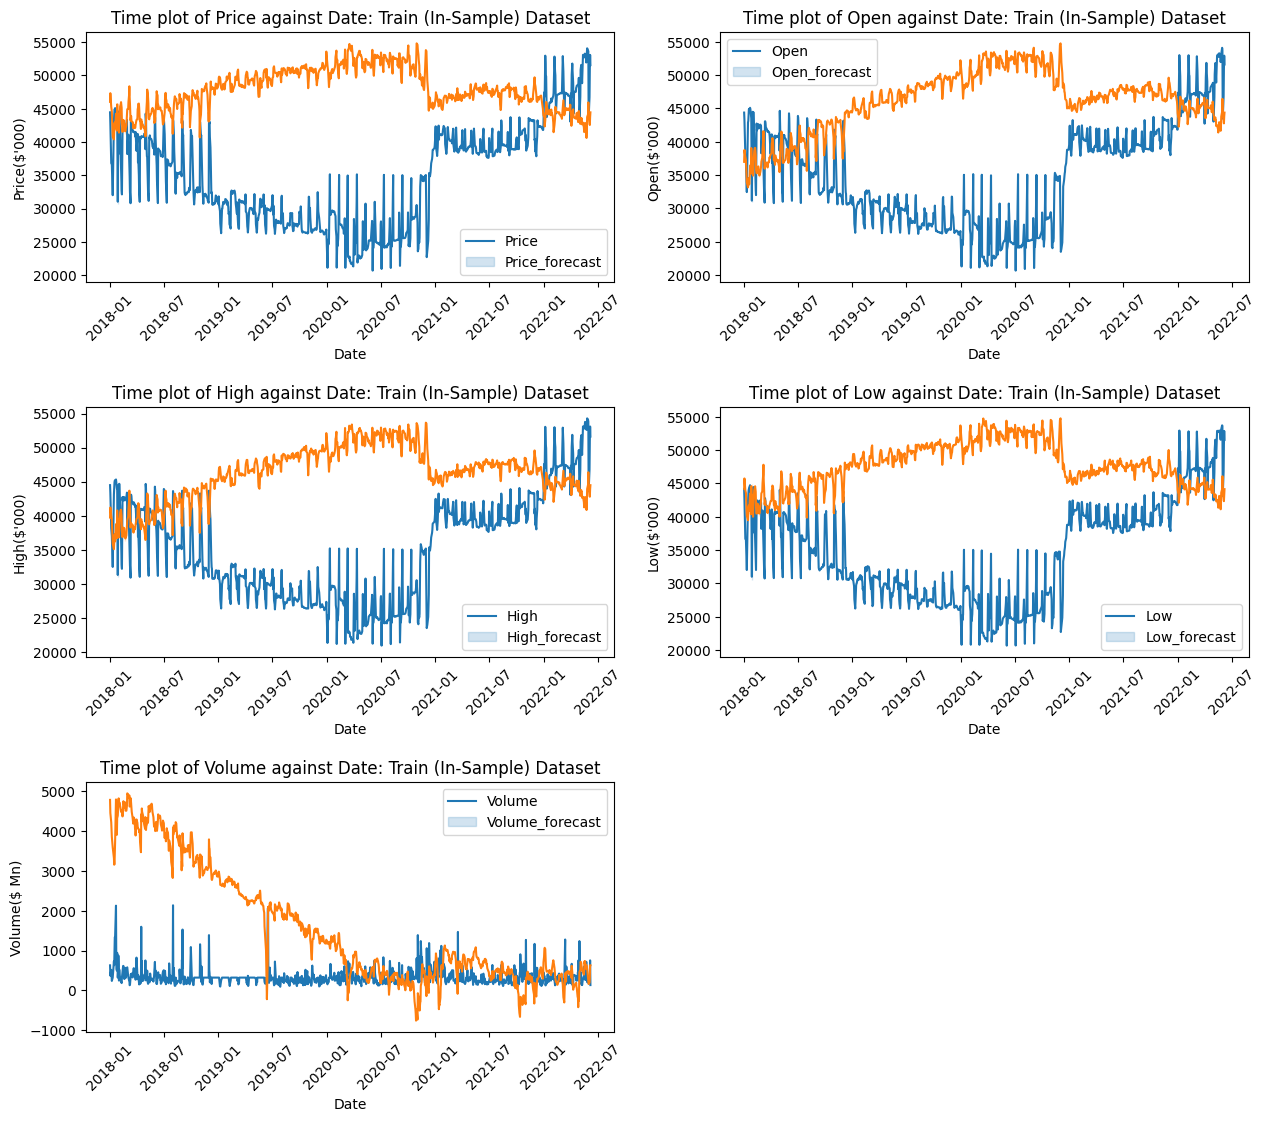

In [54]:
def time_series_plot():
        plt.figure(figsize=[15,25])
        plt.subplots_adjust(hspace=0.5,bottom=0.1, top=0.5)

        plt.subplot(3,2,1)
        sns.lineplot(data=df_train_comb, x = df_train_comb.index, y = 'Price')
        sns.lineplot(data=df_train_comb, x = df_train_comb.index, y = 'Price_forecast')
        plt.title('Time plot of Price against Date: Train (In-Sample) Dataset')
        plt.xlabel('Date')
        plt.ylabel("Price($'000)")
        plt.xticks(rotation=45)
        plt.legend(['Price','Price_forecast'])


        plt.subplot(3,2,2)
        sns.lineplot(data=df_train_comb, x = df_train_comb.index, y = 'Open')
        sns.lineplot(data=df_train_comb, x = df_train_comb.index, y = 'Open_forecast')
        plt.title('Time plot of Open against Date: Train (In-Sample) Dataset')
        plt.xlabel('Date')
        plt.ylabel("Open($'000)")
        plt.xticks(rotation=45)
        plt.legend(['Open','Open_forecast'])

        plt.subplot(3,2,3)
        sns.lineplot(data=df_train_comb, x = df_train_comb.index, y = 'High')
        sns.lineplot(data=df_train_comb, x = df_train_comb.index, y = 'High_forecast')
        plt.title('Time plot of High against Date: Train (In-Sample) Dataset')
        plt.xlabel('Date')
        plt.ylabel("High($'000)")
        plt.xticks(rotation=45)
        plt.legend(['High','High_forecast'])

        plt.subplot(3,2,4)
        sns.lineplot(data=df_train_comb, x = df_train_comb.index, y = 'Low')
        sns.lineplot(data=df_train_comb, x = df_train_comb.index, y = 'Low_forecast')
        plt.title('Time plot of Low against Date: Train (In-Sample) Dataset')
        plt.xlabel('Date')
        plt.ylabel("Low($'000)")
        plt.xticks(rotation=45)
        plt.legend(['Low','Low_forecast'])

        plt.subplot(3,2,5)
        sns.lineplot(data=df_train_comb, x = df_train_comb.index, y = 'Volume')
        sns.lineplot(data=df_train_comb, x = df_train_comb.index, y = 'Volume_forecast')
        plt.title('Time plot of Volume against Date: Train (In-Sample) Dataset')
        plt.xlabel('Date')
        plt.ylabel("Volume($ Mn)")
        plt.xticks(rotation=45)
        plt.legend(['Volume','Volume_forecast'])
        plt.savefig("Time_plot_train_pred.jpg", bbox_inches='tight', dpi=150)


time_series_plot()

In [179]:
# Evaluation metrics for train dataset
for col in df_train_c.columns:
    print(f"Evaluation meteric for {col}")
    series_eval_metric(df_train_c[str(col)], df_train_pred[str(col)+'_forecast'])
    
    

Evaluation meteric for Price
Evaluation metric results:-
MAE is : 0.3879975055489396
MAPE is : 0.3879975055489396
R2 is : -2.220464548873358
MSE is : 183076567.1320541
RMSE is : 13530.5789651461

Evaluation meteric for Open
Evaluation metric results:-
MAE is : 0.389719741298931
MAPE is : 0.389719741298931
R2 is : -2.290318653978879
MSE is : 186232569.040101
RMSE is : 13646.705428054824

Evaluation meteric for High
Evaluation metric results:-
MAE is : 0.3734576961789083
MAPE is : 0.3734576961789083
R2 is : -2.032461571727945
MSE is : 172434187.5688781
RMSE is : 13131.419861114719

Evaluation meteric for Low
Evaluation metric results:-
MAE is : 0.40171045752959555
MAPE is : 0.40171045752959555
R2 is : -2.4489154117269303
MSE is : 194731749.9426645
RMSE is : 13954.631845472115

Evaluation meteric for Volume
Evaluation metric results:-
MAE is : 2.447006638297204
MAPE is : 2.447006638297204
R2 is : -17.809621759354226
MSE is : 865958.3816724523
RMSE is : 930.5688484322116



In [180]:
# Viewing the test dataset
print(df_test.head())
df_test.tail()

               Price      Open      High       Low  Volume
Date                                                      
2022-12-02  47531.84  47565.92  47572.78  47529.93  155.18
2022-12-01  49626.05  49695.12  49703.85  49626.05   86.59
2022-11-30  49664.07  50017.51  50017.51  49371.37  272.07
2022-11-29  52917.76  52844.84  53069.29  52843.48  426.02
2022-11-28  47205.03  46872.25  47231.66  46872.25  245.42


,Price,Open,High,Low,Volume
Date,,,,,
2022-06-17,51778.08,52411.09,52451.43,51755.18,241.19
2022-06-16,52411.09,52775.40,52783.52,52374.04,211.61
2022-06-15,52775.40,53113.64,53113.64,52773.20,188.09
2022-06-14,53114.65,53201.38,53202.13,53097.77,299.81
2022-06-10,47260.89,48836.70,48890.97,47238.35,140.66


In [48]:
# Predicting the test dataset
pred_test = model.forecast(steps= len(df_test))
print(f"Length of original test dataset: {len(df_test)}")
print(f"Length of predicted test dataset: {len(pred_test)}")
print(pred_test.head())
pred_test.tail()

Length of original test dataset: 121
Length of predicted test dataset: 121
           Price        Open        High         Low     Volume
1094 -958.312860 -691.719732 -582.528603 -987.065400 -28.217572
1095  376.308252  371.915842  360.858585  372.316724  -2.459763
1096  -88.679151  -96.669246  -90.364262  -94.438578   7.346472
1097    9.445564   10.295783    9.550434   11.279586  -0.038230
1098   -7.543978   -8.476355   -8.111763   -8.243570   0.545053


,Price,Open,High,Low,Volume
1210,-4.459534,-5.035853,-4.844379,-4.778603,0.723093
1211,-4.459534,-5.035853,-4.844379,-4.778603,0.723093
1212,-4.459534,-5.035853,-4.844379,-4.778603,0.723093
1213,-4.459534,-5.035853,-4.844379,-4.778603,0.723093
1214,-4.459534,-5.035853,-4.844379,-4.778603,0.723093


In [49]:
# Inverting the test forecast
idx = pd.date_range(start='2022-12-02', end='2022-06-10')
test_pred_output = inverse_diff(df_test, pred_test)
test_pred_output.head()


,Price,Open,High,Low,Volume,Price_forecast,Open_forecast,High_forecast,Low_forecast,Volume_forecast
1094,-958.312860,-691.719732,-582.528603,-987.065400,-28.217572,46302.577140,48144.980268,48308.441397,46251.284600,112.442428
1095,376.308252,371.915842,360.858585,372.316724,-2.459763,46678.885392,48516.896110,48669.299981,46623.601324,109.982665
1096,-88.679151,-96.669246,-90.364262,-94.438578,7.346472,46590.206241,48420.226865,48578.935720,46529.162746,117.329137
1097,9.445564,10.295783,9.550434,11.279586,-0.038230,46599.651805,48430.522648,48588.486154,46540.442332,117.290907
1098,-7.543978,-8.476355,-8.111763,-8.243570,0.545053,46592.107827,48422.046293,48580.374391,46532.198763,117.835960


In [50]:
# Selecting the test forecast variables
test_pred_output_samp = test_pred_output.loc[:, 'Price_forecast':]
test_pred_output_samp.head()


,Price_forecast,Open_forecast,High_forecast,Low_forecast,Volume_forecast
1094,46302.577140,48144.980268,48308.441397,46251.284600,112.442428
1095,46678.885392,48516.896110,48669.299981,46623.601324,109.982665
1096,46590.206241,48420.226865,48578.935720,46529.162746,117.329137
1097,46599.651805,48430.522648,48588.486154,46540.442332,117.290907
1098,46592.107827,48422.046293,48580.374391,46532.198763,117.835960


In [51]:
# Make a copy of the test dataset
df_test_copy = df_test.copy()
# Create a Series object
x = np.linspace(1094, 1214, 121)
# Add the Series object as a column to the copied test dataframe
df_test_copy['index_col'] = x 
# Change column dtype from float to int
df_test_copy['index_col'] = df_test_copy['index_col'].astype(int)
# Make column as index column
df_test_copy.set_index('index_col', inplace=True)
# Combine predicted dataframe with the copied test dataframe
df_test_comb = df_test_copy.join(test_pred_output_samp)
# Changing the index column to datetime format
df_test_comb['Newest_index'] = df_test.index
# Making the newest column index column
df_test_comb.set_index('Newest_index', inplace=True)
# Save the new test predict dataframe
df_test_comb.to_csv("df_test_&_pred.csv")
# View the new test dataframe
df_test_comb.head()


,Price,Open,High,Low,Volume,Price_forecast,Open_forecast,High_forecast,Low_forecast,Volume_forecast
Newest_index,,,,,,,,,,
2022-12-02,47531.84,47565.92,47572.78,47529.93,155.18,46302.577140,48144.980268,48308.441397,46251.284600,112.442428
2022-12-01,49626.05,49695.12,49703.85,49626.05,86.59,46678.885392,48516.896110,48669.299981,46623.601324,109.982665
2022-11-30,49664.07,50017.51,50017.51,49371.37,272.07,46590.206241,48420.226865,48578.935720,46529.162746,117.329137
2022-11-29,52917.76,52844.84,53069.29,52843.48,426.02,46599.651805,48430.522648,48588.486154,46540.442332,117.290907
2022-11-28,47205.03,46872.25,47231.66,46872.25,245.42,46592.107827,48422.046293,48580.374391,46532.198763,117.835960


In [52]:
# Evaluation or validation metrics for test dataset with its prediction
for col in df_test.columns:
    print(f"Evaluation meteric for {col}")
    series_eval_metric(df_test[str(col)], test_pred_output_samp[str(col)+'_forecast'])

Evaluation meteric for Price
Evaluation metric results:-
MAE is : 0.06527215516792975
MAPE is : 0.06527215516792975
R2 is : -0.6872625098363401
MSE is : 13979470.17224206
RMSE is : 3738.9129666578306

Evaluation meteric for Open
Evaluation metric results:-
MAE is : 0.054585381932588016
MAPE is : 0.054585381932588016
R2 is : -0.10303827528535447
MSE is : 9209377.387639394
RMSE is : 3034.695600490994

Evaluation meteric for High
Evaluation metric results:-
MAE is : 0.053796476417745376
MAPE is : 0.053796476417745376
R2 is : -0.09840925796744582
MSE is : 9010316.766619004
RMSE is : 3001.718968627644

Evaluation meteric for Low
Evaluation metric results:-
MAE is : 0.06541937883209972
MAPE is : 0.06541937883209972
R2 is : -0.642969056557648
MSE is : 13748039.40075925
RMSE is : 3707.8348669755037

Evaluation meteric for Volume
Evaluation metric results:-
MAE is : 0.33615366140381875
MAPE is : 0.33615366140381875
R2 is : -0.21123914548644462
MSE is : 20523.489274032963
RMSE is : 143.260215251

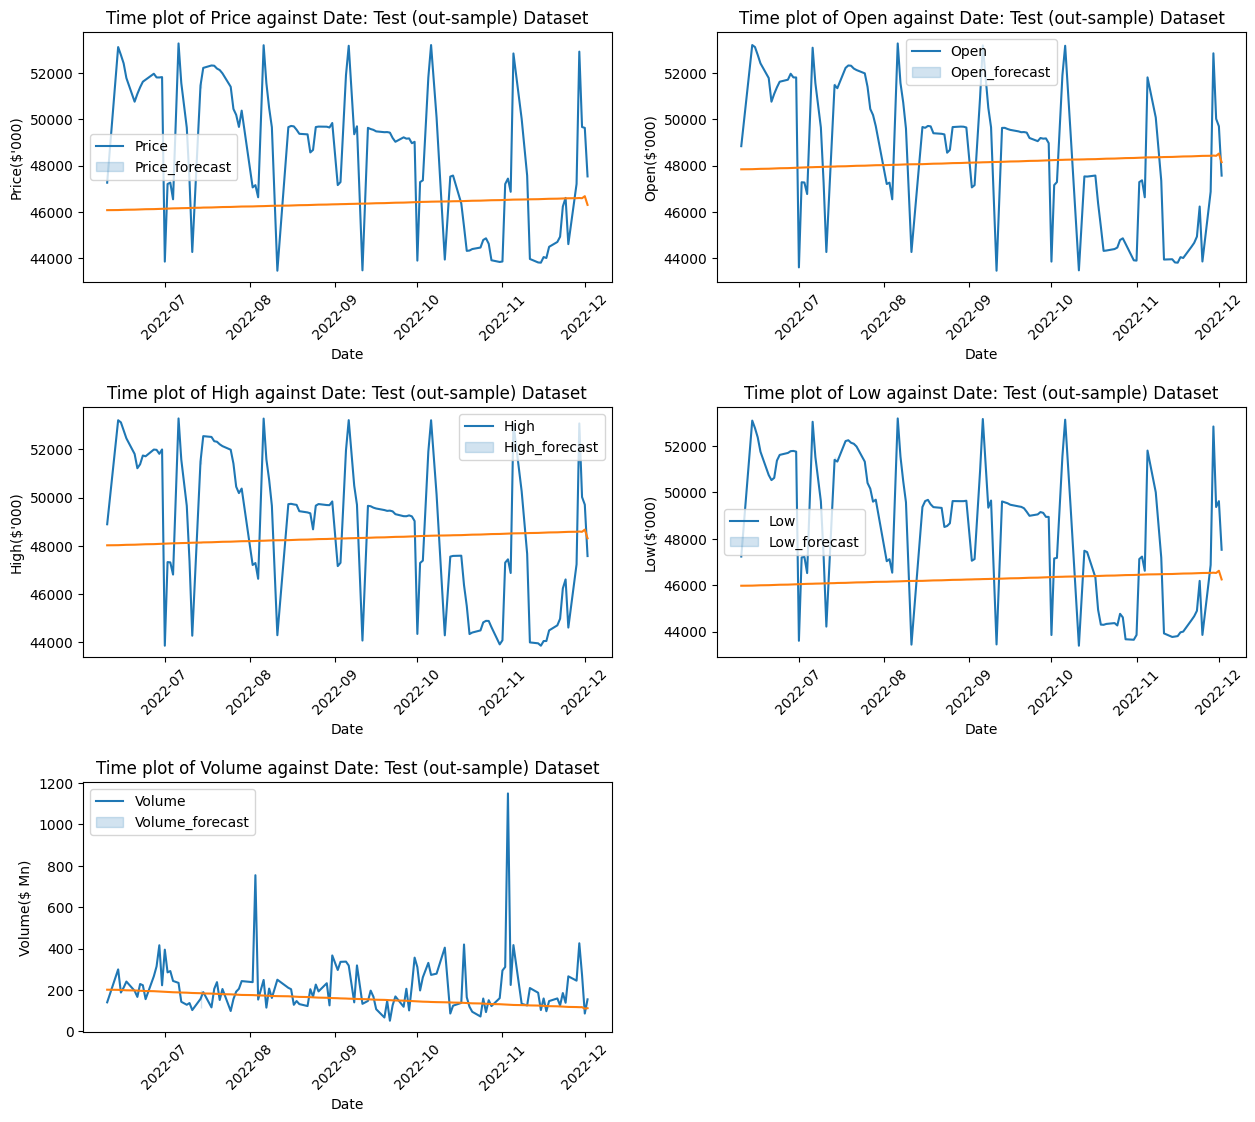

In [53]:
# Make a time series plot of test dataset and its predicted values
def time_series_plot2():
        plt.figure(figsize=[15,25])
        plt.subplots_adjust(hspace=0.5,bottom=0.1, top=0.5)

        plt.subplot(3,2,1)
        sns.lineplot(data=df_test_comb, x = df_test_comb.index, y = 'Price')
        sns.lineplot(data=df_test_comb, x = df_test_comb.index, y = 'Price_forecast')
        plt.title('Time plot of Price against Date: Test (out-sample) Dataset')
        plt.xlabel('Date')
        plt.ylabel("Price($'000)")
        plt.xticks(rotation=45)
        plt.legend(['Price','Price_forecast'])


        plt.subplot(3,2,2)
        sns.lineplot(data=df_test_comb, x = df_test_comb.index, y = 'Open')
        sns.lineplot(data=df_test_comb, x = df_test_comb.index, y = 'Open_forecast')
        plt.title('Time plot of Open against Date: Test (out-sample) Dataset')
        plt.xlabel('Date')
        plt.ylabel("Open($'000)")
        plt.xticks(rotation=45)
        plt.legend(['Open','Open_forecast'])

        plt.subplot(3,2,3)
        sns.lineplot(data=df_test_comb, x = df_test_comb.index, y = 'High')
        sns.lineplot(data=df_test_comb, x = df_test_comb.index, y = 'High_forecast')
        plt.title('Time plot of High against Date: Test (out-sample) Dataset')
        plt.xlabel('Date')
        plt.ylabel("High($'000)")
        plt.xticks(rotation=45)
        plt.legend(['High','High_forecast'])

        plt.subplot(3,2,4)
        sns.lineplot(data=df_test_comb, x = df_test_comb.index, y = 'Low')
        sns.lineplot(data=df_test_comb, x = df_test_comb.index, y = 'Low_forecast')
        plt.title('Time plot of Low against Date: Test (out-sample) Dataset')
        plt.xlabel('Date')
        plt.ylabel("Low($'000)")
        plt.xticks(rotation=45)
        plt.legend(['Low','Low_forecast'])

        plt.subplot(3,2,5)
        sns.lineplot(data=df_test_comb, x = df_test_comb.index, y = 'Volume')
        sns.lineplot(data=df_test_comb, x = df_test_comb.index, y = 'Volume_forecast')
        plt.title('Time plot of Volume against Date: Test (out-sample) Dataset')
        plt.xlabel('Date')
        plt.ylabel("Volume($ Mn)")
        plt.xticks(rotation=45)
        plt.legend(['Volume','Volume_forecast'])
        plt.savefig("Time_plot_test_pred.jpg", bbox_inches='tight', dpi=150)


time_series_plot2()